<a href="https://colab.research.google.com/github/vishnudas08/Digit-Recognition-using-CNN/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt



In [ ]:
import os
from torch.utils.data import DataLoader, random_split

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -q kagglecatsanddogs_5340.zip
!ls
!ls PetImages

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  98.9M      0  0:00:07  0:00:07 --:--:-- 68.9M
 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'
Cat  Dog


In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="PIL.TiffImagePlugin")

In [ ]:
data_path= '/content/PetImages'
os.listdir(data_path)

['Dog', 'Cat']

In [ ]:
def load_and_clean_images(directory):

    class_names = ['Cat', 'Dog']
    corrupted_files= []

    for  class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
          print(f"directory not found: {class_dir}")
          continue
        for file in os.listdir(class_dir):
            if file.endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(class_dir, file)
                try:
                  with open(img_path, 'rb') as f:
                    f.seek(0,2)
                    size = f.tell()
                  if size == 0:
                    print(f"empyt eile {img_path}")
                    corrupted_files.append(img_path)
                    continue
                  img = cv2.imread(img_path)
                  if img is None:
                        print(f"Corrupted image: {img_path}")
                        corrupted_files.append(img_path)
                        continue

                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
                    corrupted_files.append(img_path)
    print(f" found {len(corrupted_files)} corrupted or empty files")
    for file_path in corrupted_files:
      try:
        os.remove(file_path)
        print(f"Removed {file_path}")
      except OSError as e:
        print(f"error removing file {file_path} : {e}")

load_and_clean_images(data_path)

 found 0 corrupted or empty files


In [ ]:
transform= transforms.Compose([
    transforms.Resize((64,64)),

    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
])

dataset= datasets.ImageFolder(root= data_path, transform=transform)
train= int(0.8 * len(dataset))
val= len(dataset) -train
train_dataset, test_dataset =random_split(dataset,[train, val])
print(len(train_dataset),
len(test_dataset) )


19997 5000


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
print(dataset.class_to_idx)

{'Cat': 0, 'Dog': 1}


In [ ]:
class imageClassifier(nn.Module):
  def __init__(self):
    super (). __init__()
    self.network= nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(5,5), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2),

        nn.Conv2d(64,128,  (3, 3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(128, 224,  (3, 3),  padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(224),
        nn.MaxPool2d(2, 2),



        nn.Flatten(),
            nn.Linear(224 * 7* 7, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),  # Binary classification
            nn.Sigmoid()
        )


  def forward(self, x):
        return self.network(x)

In [ ]:
model= imageClassifier()

In [ ]:
loss_fn=nn.BCELoss()
optimizer=optim.Adam(model.parameters(), lr=0.006)
epochs=20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images, labels.float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    #print(f"Epoch {epoch+1} loss: {running_loss:.2f}")
    print(f"epoch [{epoch+1}/{epochs}] loss: {running_loss:.2f}")

epoch [1/20] loss: 2155.06
epoch [2/20] loss: 206.15
epoch [3/20] loss: 200.68
epoch [4/20] loss: 198.95
epoch [5/20] loss: 192.29
epoch [6/20] loss: 179.07
epoch [7/20] loss: 172.42
epoch [8/20] loss: 160.50
epoch [9/20] loss: 149.50


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
      images, labels = images , labels.float().unsqueeze(1)


      outputs = model(images)
      predicted = (outputs >0.5 ).float()
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
print(f"total : {total}, predict_correct: {correct}")
print(f'Accuracy: {100 * correct / total:.2f}%')


total : 5000, predict_correct: 4192
Accuracy: 83.84%


In [ ]:
from sklearn.metrics import precision_score,recall_score, f1_score, confusion_matrix,classification_report
import seaborn as sns
import numpy as np

Precision: 0.8619
Recall: 0.8021
F1-Score: 0.8309

Confusion Matrix:
[[2172  322]
 [ 496 2010]]


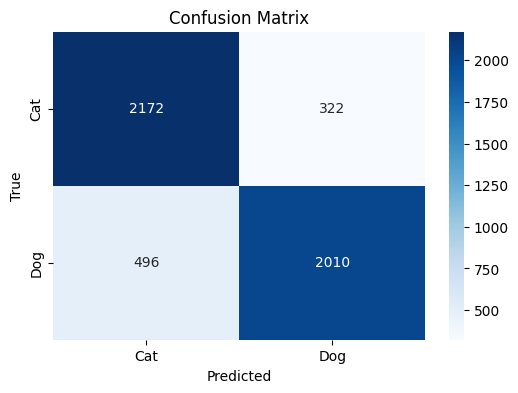

In [ ]:
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
  for images, labels in test_dataloader:
    images, labels = images , labels.float().unsqueeze(1)


    preds = model(images)
    # Convert probabilities to binary predictions (threshold = 0.5)
    preds_binary = (preds > 0.5).float()

    y_pred.extend(preds_binary.cpu().numpy().flatten())
    y_true.extend(labels.cpu().flatten()) # Move to CPU and convert to list

    if len(y_true) >= 5000:
       break

# Convert lists to numpy arrays for sklearn metrics
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Step 2: Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Step 3: Compute and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Optional: Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84      2494
         1.0       0.86      0.80      0.83      2506

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



In [ ]:
import numpy as np
import cv2
from PIL import Image
import torchvision.transforms as transforms

In [ ]:
test_img=cv2.imread('/content/Gemini_Generated_Image_ytjnlqytjnlqytjn.png')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

In [ ]:


img_pil = Image.fromarray(test_img)

img_tensor = transform(img_pil)
img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor
model = model

In [ ]:
img_pil = Image.fromarray(test_img)
img_tensor = transform(img_pil)

In [ ]:
print(type(img_tensor))
print(img_tensor.shape)

<class 'torch.Tensor'>
torch.Size([3, 32, 32])


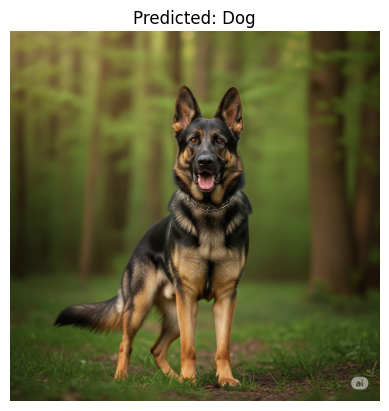

In [ ]:

model.eval()
with torch.no_grad():
    output = model(img_tensor)  # output is a probability because of Sigmoid
    prediction = (output > 0.5).float().item()  # Threshold at 0.5 for binary classification

# Print predicted label
if prediction == 1.0:
    label = "Dog"
else:
    label = "Cat"

# Show image with predicted label
plt.imshow(img_pil)
plt.title(f"Predicted: {label}")
plt.axis('off')
plt.show()